# Signal processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import os
import scipy
import scipy.signal as signal
import math

# Identify import path (signal folder path) and list data

In [ ]:
path = r"D:\DLITE\Data\LWA_antenna_independantly\data_2_FEE"           # Path to the data folder
path_save_fig = "D:\DLITE\Sun_Observering_Interferometry\Result_Image"         # Path to save the figures

# Get list of folder names from data path
data_folder_list = os.listdir(path)
number_folder = len(data_folder_list)

# Sort the folder names
data_folder_list.sort()
data_folder_list

print ("Number of folders: ", number_folder)
len(data_folder_list)

Number of folders:  2


2

In [3]:
def get_folder_file_list(path, folder):

    _file_list = os.listdir(path + '\\' + folder)
    _file_list.sort()
  
    _number_file = 0
    _file_index = 0

    for file in _file_list:
        if  file < str(f"{folder}_10_00_00_PSD.csv"):
            _file_index += 1
            continue
        elif file > str(f"{folder}_14_00_00_PSD.csv"):
            continue
        
        _number_file += 1

    _frequency =  np.loadtxt(os.path.join(path + '\\' + folder, _file_list[0]), delimiter=',')[:,0]

    _timeStamp_list = np.zeros(_number_file)
    _timeString_list = ["" for i in range(_number_file)]

    for file in _file_list:
        if  file < str(f"{folder}_10_00_00_PSD.csv") or file > str(f"{folder}_14_00_00_PSD.csv"):
            continue

        # Split the string into its components
        components = file.split("_")
        # Extract the date and time components
        date_str = f"{components[0]}-{components[1]}-{components[2]}"
        time_str = f"{components[3]}:{components[4]}:{components[5]}"
        _timeString_list[_file_list.index(file) - _file_index] = time_str
        # Combine the date and time components into a single string
        dateTime_str = f"{date_str} {time_str}"
        
        # Parse the string into a datetime object
        dateTime = datetime.datetime.strptime(dateTime_str, '%Y-%m-%d %H:%M:%S')
        _timeStamp_list[_file_list.index(file) - _file_index] = dateTime.timestamp()

    return _file_list, _frequency, _timeStamp_list, _timeString_list, _number_file

# Hàm tính power 

In [4]:
def calculate_power(path, folder, file_list, number_file, Frequency):

    power_list = np.zeros(number_file)
    data_matrix = np.zeros((len(Frequency), number_file))

    _file_index = 0

    for file in file_list:
        if  file < str(f"{folder}_10_00_00_PSD.csv"):
            _file_index += 1

    for file in file_list:

        if  file < str(f"{folder}_10_00_00_PSD.csv") or file > str(f"{folder}_14_00_00_PSD.csv"):
            continue

        data = np.loadtxt(os.path.join(path + "\\" + folder, file), delimiter=',')
        data_matrix[:, file_list.index(file) - _file_index] = data[:, 1]
        power_list[file_list.index(file) - _file_index] = data[:, 1].mean()
# data[:, 1] nghĩa là: lấy tất cả các giá trị từ cột thứ hai của dữ liệu được tải từ tệp CSV hiện tại.
#.mean() nghĩa là: tính giá trị trung bình cộng của tất cả các giá trị trong cột thứ hai đó.
    print(power_list)
    return power_list, data_matrix


In [5]:
def plot_graph(time_list, power_list, date):
    fig, ax = plt.subplots(1, 1, figsize = [24, 8])
    ax.set_title(f'DLITE radio - Quy Nhon - {date}', fontsize=20)
    ax.set(xlabel = 'Time(s)', ylabel = 'Signal(dB)')
    ax.grid()
    ax.plot(time_list, power_list, color = 'green', linestyle = '-')

    x = np.arange(0, len(time_list))
    plt.xticks(x[::len(time_list)//25], time_list[::len(time_list)//25], rotation=45, ha='right')
    plt.autoscale()
    plt.show()

    fig.savefig(f"{path_save_fig}\\avg_power\\radioQN_{date}.png", dpi=600, bbox_inches='tight')
    return

# Remove spike


In [6]:
def remove_spike(x, threshold=3, window_size=11):
    """
    Remove spikes from the x-axis.

    Parameters:
    x (numpy array): The x-axis to remove spikes from.
    threshold (float): The threshold to define spikes. Default value is 3.
    window_size (int): The size of the window to calculate the average. Default value is 11.

    Returns:
    x_smooth (numpy array): The x-axis with spikes removed.
    """
    # Calculate the mean of x
    x_mean = np.mean(x)

    # Calculate the standard deviation of x
    x_std = np.std(x)

    # Finding the indices of spikes
    spike = np.abs(x - x_mean) > threshold * x_std

    # Removing the spike
    x_smooth = np.copy(x)
    x_smooth[spike] = np.mean(x[~spike])

    # Using linear interpolation
    # x_smooth[spike] = np.interp(np.where(spike)[0], np.where(~spike)[0], x[~spike])           # Bad

    # Using Savitzky-Golay filter
    # x_smooth = signal.savgol_filter(x_smooth, window_size, 3)                                 # Dependence on Threshold

    # Using convolution
    x_smooth = np.convolve(x, np.ones(window_size)/window_size, mode='same')                    # Good

    return x_smooth


In [7]:
def plot_histogram(data_matrix, Frequency, time_list, date):
    fig, ax = plt.subplots(1, 1, figsize = [24, 8], layout = 'constrained')
    ax.set_title(f'Interferometry 610MHz at Hoa Lac - Ha Noi - {date}', fontsize=20)
    ax.set_xlabel('Time(hh:mm:ss) UTC+07', fontsize=16)
    ax.set_ylabel('Frequency(MHz)', fontsize=16)
    plt.imshow(data_matrix, cmap = 'inferno', interpolation = 'nearest', aspect = 'auto', origin = 'lower')
    x = np.arange(0, len(time_list))
    plt.xticks(x[::len(time_list)//50], time_list[::len(time_list)//50], rotation=45, ha='right')
    y = np.arange(0, 512)
    plt.yticks(y[::len(Frequency)//8], Frequency[::len(Frequency)//8], rotation=0, ha='right')
    plt.colorbar()
    fig.savefig(f'{path_save_fig}\\histogram\\Interferometry_610MHz_at_Hoa_Lac_Ha_Noi_{date}.png', dpi=600, bbox_inches='tight')
    plt.show()

In [8]:
# mean_power_matrix = np.zeros((1433, number_folder))

# for folder in data_folder_list:
    # number_file = 0

    # file_list, Frequency, timeStamp_list, timeString_list, number_file = get_folder_file_list(path, folder)
    # power_list, data_matrix = calculate_power(path, folder, file_list, number_file, Frequency)

    # remove_spike(power_list, threshold=3, window_size=21)
    # np.savetxt(os.path.join(path, f'mean_power.csv'), np.c_[power_list], delimiter=',', fmt='%f')

    # mean_power_matrix[:, data_folder_list.index(folder)] = power_list

    # Plot the graph and histogram
    # plot_graph(timeString_list, power_list, folder)
    # plot_histogram(data_matrix, Frequency, timeString_list, folder)



In [9]:
valid_data = []  # Danh sách chứa các folder và dữ liệu hợp lệ

# Bước 1: Duyệt và lọc các folder có dữ liệu hợp lệ
for folder in data_folder_list:
    folder_path = os.path.join(path, folder)
    if not os.path.isdir(folder_path):
        continue

    file_list, Frequency, timeStamp_list, timeString_list, number_file = get_folder_file_list(path, folder)
    power_list, data_matrix = calculate_power(path, folder, file_list, number_file, Frequency)

    if power_list is None or len(power_list) == 0:
        continue
    if np.all(power_list == 0) or np.isnan(power_list).all():
        continue

    # Nếu hợp lệ, thêm vào danh sách
    valid_data.append((folder, timeString_list, power_list))

# Bước 2: Tạo subplot đúng với số lượng hợp lệ
n = len(valid_data)
cols = 3
rows = math.ceil(n / cols)

fig, ax_graph = plt.subplots(rows, cols, figsize=[30, 4 * rows], layout='constrained')

# Logic mới để đảm bảo ax_graph là một danh sách phẳng
if isinstance(ax_graph, np.ndarray):
    ax_graph = ax_graph.flatten()
else:
    ax_graph = [ax_graph]

# Bước 3: Vẽ biểu đồ
for idx, (folder, time_list, power_list) in enumerate(valid_data):
    ax = ax_graph[idx]
    
    # Mã này sẽ hoạt động đúng sau khi sửa Bước 2
    ax.set_ylabel('Signal(dB)')
    ax.grid(True)
    ax.plot(time_list, power_list, color='green', linestyle='-')
    ax.set_title(f'{folder}', fontsize=13)

    x = np.arange(len(time_list))
    step = max(1, len(time_list) // 20)
    ax.set_xticks(x[::step])
    ax.set_xticklabels(time_list[::step], rotation=45, ha='right')

# Bước 4: Ẩn các ô thừa nếu có
for j in range(len(valid_data), len(ax_graph)):
    fig.delaxes(ax_graph[j])

plt.show()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

[-37.81733957 -36.98337423 -37.88566234 -37.86993377 -37.83767717
 -37.93015312 -37.92894024 -37.85572071 -37.93449552 -37.98304613
 -38.01807682 -37.97723866 -36.97320776 -37.98420159 -37.99008706
 -38.00105426 -37.97098492 -37.9680828  -37.96615982 -37.92884666
 -37.93431642 -37.9320293  -37.92212731 -37.10657752 -37.8951121
 -37.86005347 -37.86764976 -37.84409426 -37.8736743  -37.84079191
 -37.83869369 -37.81650544 -37.81069066 -37.81335111 -37.88566234
 -37.81307949 -37.78095176 -37.79285704 -37.77684251 -37.76821872
 -37.77983945 -37.81660901 -37.90689432 -37.87614672 -37.84334479
 -37.98420159 -37.78285918 -37.8007516  -37.78454894 -37.76479805
 -37.81435606 -37.93809452 -37.97414172 -37.98260479 -37.94174051
 -37.88496323 -37.8951121  -37.84472999 -37.8446347  -37.75918292
 -37.7755523  -37.66720936 -37.58079237 -37.55844381 -37.54579469
 -37.54087632 -37.46494476 -37.81307949 -37.48166135 -37.44990773
 -37.41633985 -37.42406383 -37.4071658  -37.43835045 -37.43633489
 -37.430868

AttributeError: 'numpy.ndarray' object has no attribute 'set'

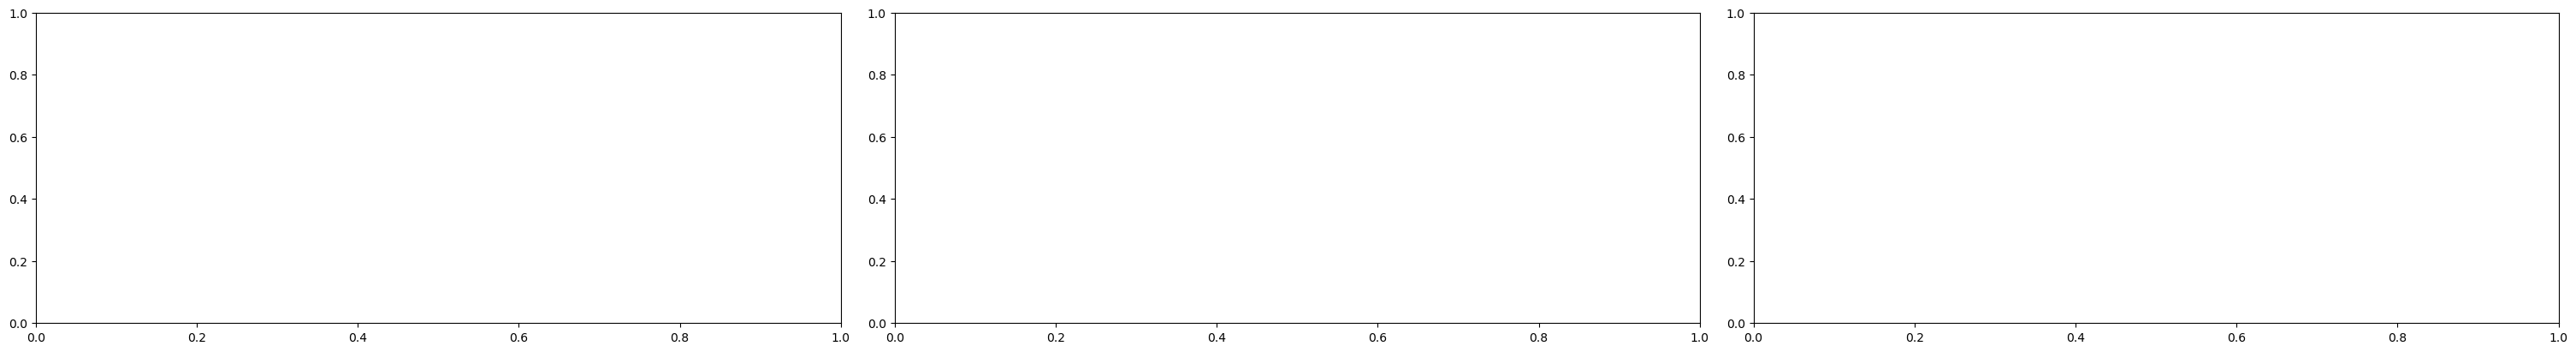

In [ ]:
# Danh sách dữ liệu hợp lệ
valid_data = []

for folder in data_folder_list:
    folder_path = os.path.join(path, folder)
    if not os.path.isdir(folder_path):
        continue

    file_list, Frequency, timeStamp_list, timeString_list, number_file = get_folder_file_list(path, folder)

    # Bỏ qua nếu không có dữ liệu hợp lệ
    if Frequency is None or number_file == 0 or not file_list:
        continue

    power_list, data_matrix = calculate_power(path, folder, file_list, number_file, Frequency)

    if data_matrix is None or np.all(data_matrix == 0) or np.isnan(data_matrix).all():
        continue

    # ✅ Áp dụng remove_spike theo từng dòng (từng bin tần số theo thời gian)
    for i in range(data_matrix.shape[0]):
        data_matrix[i, :] = remove_spike(data_matrix[i, :], threshold=3, window_size=11)

    valid_data.append((folder, timeString_list, Frequency, data_matrix))

# Tạo figure
n = len(valid_data)
cols = 3
rows = math.ceil(n / cols)
fig, ax_graph = plt.subplots(rows, cols, figsize=[30, 4 * rows], layout='constrained')
ax_graph = ax_graph.flatten() if n > 1 else [ax_graph]

# Vẽ biểu đồ
for idx, (folder, time_list, freq_list, matrix) in enumerate(valid_data):
    ax = ax_graph[idx]
    ax.set(ylabel='Signal (dB)')
    ax.imshow(matrix, cmap='inferno', interpolation='nearest', aspect='auto', origin='lower')
    ax.set_title(f'{folder}', fontsize=13)

    # Trục X – thời gian
    step_x = max(1, len(time_list) // 20)
    x = np.arange(len(time_list))
    ax.set_xticks(x[::step_x])
    ax.set_xticklabels(time_list[::step_x], rotation=45, ha='right')

    # Trục Y – tần số
    step_y = max(1, len(freq_list) // 8)
    y = np.arange(len(freq_list))
    ax.set_yticks(y[::step_y])
    ax.set_yticklabels(freq_list[::step_y])

# Xoá subplot dư
for j in range(len(valid_data), len(ax_graph)):
    fig.delaxes(ax_graph[j])

plt.show()

In [ ]:
len(data_folder_list)


38

In [ ]:
len(time_list)

1373

In [ ]:
# ===== Bước 1: Lọc các folder hợp lệ =====
valid_folders = []
valid_power_lists = []
timeStamp_template = None

for folder in data_folder_list:
    folder_path = os.path.join(path, folder)
    if not os.path.isdir(folder_path):
        print(f"Skipping missing folder: {folder}")
        continue

    file_list, Frequency, timeStamp_list, timeString_list, number_file = get_folder_file_list(path, folder)
    power_list, data_matrix = calculate_power(path, folder, file_list, number_file, Frequency)

    if power_list is None or np.all(power_list == 0) or np.isnan(power_list).all():
        print(f"Skipping folder {folder}: power_list is all zeros or NaN")
        continue

    # ✅ Áp dụng remove_spike
    power_list = remove_spike(power_list, threshold=3, window_size=11)

    # Lưu timestamp mẫu để gán trục Y
    if timeStamp_template is None and timeStamp_list is not None and len(timeStamp_list) > 1:
        timeStamp_template = timeStamp_list

    valid_folders.append(folder)
    valid_power_lists.append(power_list)

# ===== Bước 2: Tạo ma trận trung bình =====
number_folder_valid = len(valid_folders)
mean_power_matrix = np.zeros((1433, number_folder_valid))

for i, power_list in enumerate(valid_power_lists):
    if len(power_list) != mean_power_matrix.shape[0]:
        x_old = np.linspace(0, 1, len(power_list))
        x_new = np.linspace(0, 1, mean_power_matrix.shape[0])
        power_list_resized = np.interp(x_new, x_old, power_list)
        mean_power_matrix[:, i] = power_list_resized
    else:
        mean_power_matrix[:, i] = power_list

# ===== Bước 3: Vẽ heatmap =====
fig, ax = plt.subplots(1, 1, figsize=[24, 10], layout='constrained')
ax.set_title('Interferometry 610MHz at Hoa Lac - Ha Noi', fontsize=20)
ax.set_xlabel('Date (YYYY_MM_DD)', fontsize=16)
ax.set_ylabel('Time (hh:mm:ss) UTC+07', fontsize=16)

im = ax.imshow(mean_power_matrix, cmap='inferno', interpolation='nearest', aspect='auto', origin='lower')

# Trục X – ngày
x = np.arange(len(valid_folders))
step_x = max(1, len(valid_folders) // 34)
ax.set_xticks(x[::step_x])
ax.set_xticklabels(valid_folders[::step_x], rotation=45, ha='right')

# Trục Y – thời gian
if timeStamp_template is not None:
    step_seconds = 10
    start_ts = timeStamp_template[0]
    end_ts = timeStamp_template[-1]
    time_list = []
    current_ts = start_ts
    while current_ts <= end_ts:
        time_list.append(datetime.datetime.fromtimestamp(current_ts).strftime('%H:%M:%S'))
        current_ts += step_seconds

    y = np.arange(len(time_list))
    step_y = max(1, len(time_list) // 20)
    ax.set_yticks(y[::step_y])
    ax.set_yticklabels(time_list[::step_y], rotation=45, ha='right')

# Colorbar
plt.colorbar(im, ax=ax).set_label("Power", fontsize=14)
plt.show()


[-18.79697716 -18.79661504 -18.46815745 ... -17.23251603 -17.29817911
 -17.1848043 ]
[-21.30427848 -21.29339475 -21.39932574 ... -20.03016139 -20.17899413
 -20.01393712]
[-21.65759691 -21.67838921 -21.7188871  ... -20.73649799 -20.77474141
 -20.77903674]
[-17.99870978 -17.82948943 -17.86342479 ... -18.31972812 -18.217134
 -18.24538403]
[-16.5732133  -16.52575468 -16.50890081 ... -18.51529478 -18.37558943
 -18.50450937]
[-22.05286579 -22.03432578 -22.06268125 ... -21.46246215 -21.51925003
 -21.52879589]
[-21.92521877 -21.8967098  -21.86946529 ... -21.64436174 -21.85983612
 -21.93281406]
[-22.37116624 -22.46962611 -22.34677167 ... -21.86758868 -21.95273393
 -21.81731212]
[-21.89316643 -21.79110159 -21.95780959 ... -22.08798493 -22.07146459
 -21.94233126]
